In [1]:
import os
import json
import yaml
import time
from redis import Redis
from rq import Queue, Retry
from rq.job import Job
import traceback
import sys

import warnings
import matplotlib.cbook
from joyflo import reactflow_to_networkx

In [4]:
from FUNCTIONS.GENERATORS import *
from FUNCTIONS.TRANSFORMERS import *
from FUNCTIONS.VISORS import *

In [6]:
stream = open('STATUS_CODES.yml', 'r',encoding="utf8")
STATUS_CODES = yaml.safe_load(stream)

from utils import PlotlyJSONEncoder

import os

REDIS_HOST = os.environ.get('REDIS_HOST', 'localhost')
REDIS_PORT = os.environ.get('REDIS_PORT', 6379)

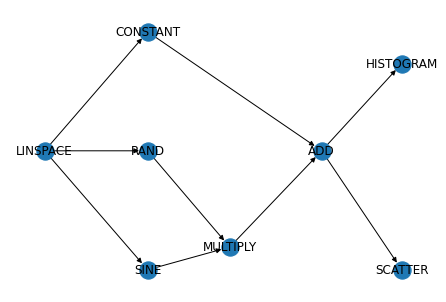

In [7]:
r = Redis(host=REDIS_HOST, port=REDIS_PORT)
q = Queue('flojoy', connection=r)


# Load React flow chart object from JSON file

f = open('./fc.json')
fc = json.loads(f.read())
elems = fc['elements']

# Replicate the React Flow chart in Python's networkx

convert_reactflow_to_networkx = reactflow_to_networkx(elems)

# get topological sorting from reactflow_to_networx function imported from flojoy package

topological_sorting = convert_reactflow_to_networkx['topological_sort']

nodes_by_id = convert_reactflow_to_networkx['getNode']()
DG = convert_reactflow_to_networkx['DG']

def report_failure(job, connection, type, value, traceback):
    print(job, connection, type, value, traceback)

def jid(n):
    return 'JOB_ID_{0}'.format(n)

In [8]:
for n in topological_sorting:
    cmd = nodes_by_id[n]['cmd']
    ctrls = nodes_by_id[n]['ctrls']
    print('*********************')
    print('node:', n, 'ctrls:', ctrls, "cmd: ", cmd,)
    print('*********************')
    # print('globals:', globals())

    func = getattr(globals()[cmd], cmd)
    print('func:', func)
    job_id = jid(n)

    s = ' '.join([STATUS_CODES['JOB_IN_RQ'], cmd.upper()])
    r.set('SYSTEM_STATUS', s)

    if len(list(DG.predecessors(n))) == 0:
        print('{0} ({1}) has no predecessors'.format(cmd, n))
        q.enqueue(func,
            retry=Retry(max=100), # TODO: have to understand why the SINE node is failing for few times then succeeds
            job_timeout='3m',
            on_failure=report_failure,
            job_id = job_id,
            kwargs={'ctrls': ctrls},
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls)
    else:
        previous_job_ids = []
        for p in DG.predecessors(n):
            prev_cmd = DG.nodes[p]['cmd']
            prev_job_id = jid(p)
            previous_job_ids.append(prev_job_id)
            print(prev_cmd, 'is a predecessor to', cmd)
        q.enqueue(func,
            retry=Retry(max=100),
            job_timeout='3m',
            on_failure=report_failure,
            job_id=job_id,
            kwargs={'ctrls': ctrls,'previous_job_ids':previous_job_ids,},
            depends_on=previous_job_ids,
            result_ttl=500)
        print('ENQUEUING...', cmd, job_id, ctrls, previous_job_ids)

*********************
node: 7 ctrls: {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}} cmd:  LINSPACE
*********************
func: <function LINSPACE at 0x000001A3A56F7130>
LINSPACE (7) has no predecessors
ENQUEUING... LINSPACE JOB_ID_7 {'LINSPACE_LINSPACE_START': {'functionName': 'LINSPACE', 'param': 'start', 'value': 1}, 'LINSPACE_LINSPACE_END': {'functionName': 'LINSPACE', 'param': 'end', 'value': 14}, 'LINSPACE_LINSPACE_STEP': {'functionName': 'LINSPACE', 'param': 'step', 'value': 3}}
*********************
node: 1 ctrls: {'SINE_SINE_FREQUENCY': {'functionName': 'SINE', 'param': 'frequency', 'value': 3}, 'SINE_SINE_AMPLITUDE': {'functionName': 'SINE', 'param': 'amplitude', 'value': 1}, 'SINE_SINE_WAVEFORM': {'functionName': 'SINE', 'param': 'waveform', 'value': 'sine'}} cmd:  SINE




Getting Node Outputs
Job status: LINSPACE finished origin: flojoy attempt: 1
Job status: SINE finished origin: flojoy attempt: 1
Job status: RAND finished origin: flojoy attempt: 1
Job status: CONSTANT finished origin: flojoy attempt: 1
Job status: MULTIPLY finished origin: flojoy attempt: 1
Job status: ADD finished origin: flojoy attempt: 1
Job status: SCATTER finished origin: flojoy attempt: 1
Job status: HISTOGRAM finished origin: flojoy attempt: 1
[{'cmd': 'LINSPACE', 'id': 'LINSPACE-userGeneratedNode_1646432683694', 'result': {'x0': array([ 1.        ,  1.01301301,  1.02602603,  1.03903904,  1.05205205,
        1.06506507,  1.07807808,  1.09109109,  1.1041041 ,  1.11711712,
        1.13013013,  1.14314314,  1.15615616,  1.16916917,  1.18218218,
        1.1951952 ,  1.20820821,  1.22122122,  1.23423423,  1.24724725,
        1.26026026,  1.27327327,  1.28628629,  1.2992993 ,  1.31231231,
        1.32532533,  1.33833834,  1.35135135,  1.36436436,  1.37737738,
        1.39039039,  

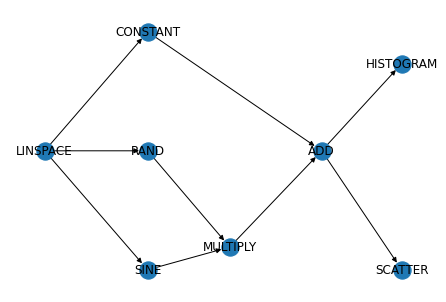

In [10]:
all_node_results = []
topological_sorting = reactflow_to_networkx(elems)['topological_sort']

print('\n\n')
print("Getting Node Outputs")

is_any_node_failed = False
for n in topological_sorting:
    job_id = jid(n)
    nd = nodes_by_id[n]
    # TODO have to investigate if and why this fails sometime
    # best is to remove this try catch, so we will have to come back to it soon
    try:
        job = Job.fetch(job_id, connection=r)
    except Exception:
        print(traceback.format_exc())
    job_status, redis_payload, attempt_count = None, None, 0
    while True: # or change it to wait for maximum amount of time, then we can declare job timed out
        time.sleep(0.5)
        job_status= job.get_status(refresh=True)
        redis_payload = job.result
        attempt_count += 1

        print('Job status:', nd['cmd'], job_status, 'origin:', job.origin, 'attempt:', attempt_count)
        if attempt_count > 9:
            job.delete()
            break
        if job_status == 'finished':
            break
        if is_any_node_failed:
            print('canceling', nd['cmd'], 'due to failure in another node')
            job.delete()
            job_status = "cancelled"
            break
        if job_status == 'failed':
            is_any_node_failed = True
            break
        if job_status == 'deferred':
            registry = q.deferred_job_registry
            registry.requeue(job_id)

    all_node_results.append({'cmd': nd['cmd'], 'id': nd['id'], 'result':redis_payload, 'job_status': job_status})
print(all_node_results)